In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [3]:
data_noise = 0.08

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

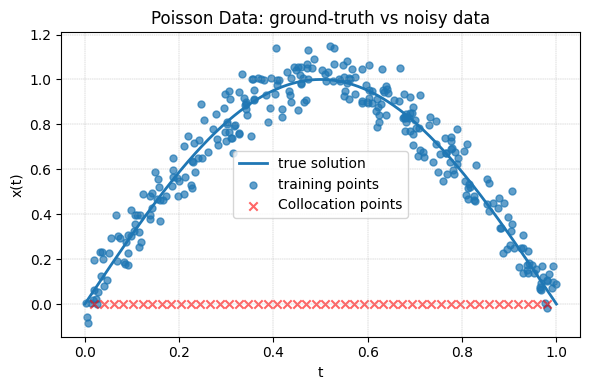

In [12]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Poisson Data: ground-truth vs noisy data"
)

In [5]:
# from draft import VIBPINN
from utils_uq_dropout import DropoutPINN
do_poisson_model = DropoutPINN(pde, 1, [16, 32, 32, 16], 1)
loss_dict = do_poisson_model.fit_do_pinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=10000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0,)

Using device: cpu
ep     1 | L=5.19e+01 | data=7.90e-01 | pde=4.79e+01  ic=0.00e+00  bc=5.17e-02 | lr=3.00e-03
ep   500 | L=2.53e+00 | data=1.17e-01 | pde=1.83e+00  ic=0.00e+00  bc=1.17e-01 | lr=3.00e-03
ep  1000 | L=2.05e+00 | data=9.02e-02 | pde=1.48e+00  ic=0.00e+00  bc=1.21e-01 | lr=3.00e-03
ep  1500 | L=2.00e+00 | data=7.84e-02 | pde=1.42e+00  ic=0.00e+00  bc=1.90e-01 | lr=3.00e-03
ep  2000 | L=2.08e+00 | data=7.65e-02 | pde=1.50e+00  ic=0.00e+00  bc=1.97e-01 | lr=3.00e-03
ep  2500 | L=1.21e+00 | data=8.97e-02 | pde=7.65e-01  ic=0.00e+00  bc=5.04e-04 | lr=3.00e-03
ep  3000 | L=1.98e+00 | data=6.31e-02 | pde=1.37e+00  ic=0.00e+00  bc=2.98e-01 | lr=3.00e-03
ep  3500 | L=1.84e+00 | data=6.76e-02 | pde=1.49e+00  ic=0.00e+00  bc=2.08e-02 | lr=3.00e-03
ep  4000 | L=2.12e+00 | data=6.79e-02 | pde=1.73e+00  ic=0.00e+00  bc=4.92e-02 | lr=3.00e-03
ep  4500 | L=1.65e+00 | data=6.02e-02 | pde=9.51e-01  ic=0.00e+00  bc=3.99e-01 | lr=3.00e-03
ep  5000 | L=1.76e+00 | data=6.33e-02 | pde=1.15e+00

In [6]:
x_grid = torch.linspace(0, 1, 100).view(-1, 1)
pred_set = do_poisson_model.predict(x_grid, n_samples=1000, alpha=0.05)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


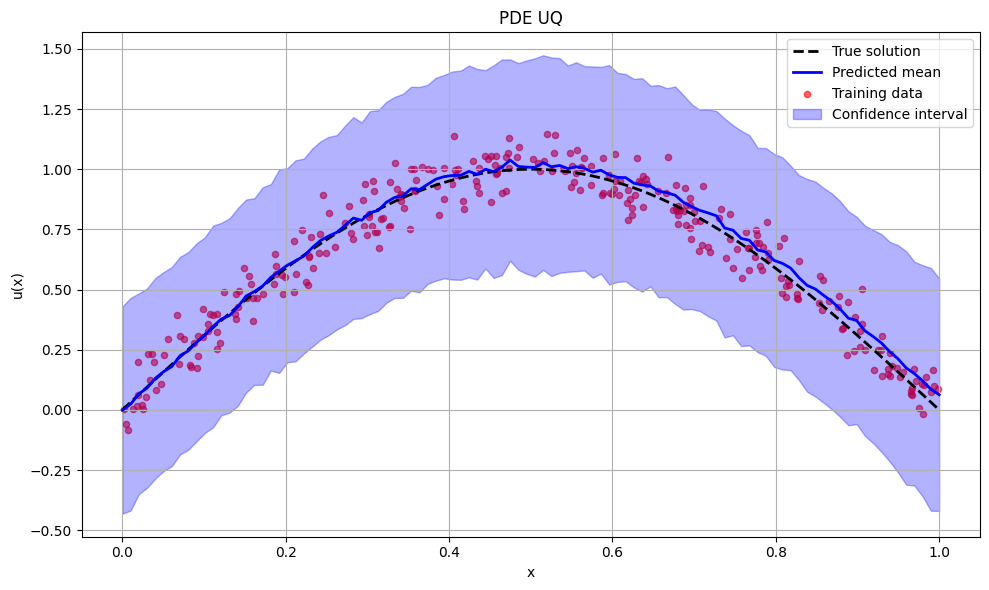

In [13]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_train, Y=Y_train)

## Sharpness & Coverage 

In [8]:
from utils_result_metrics import do_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = do_test_uncertainties(do_poisson_model, alphas, X_test, Y_test,n_samples=1000)

Using device: cpu


  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [00:01<00:00,  4.25it/s]


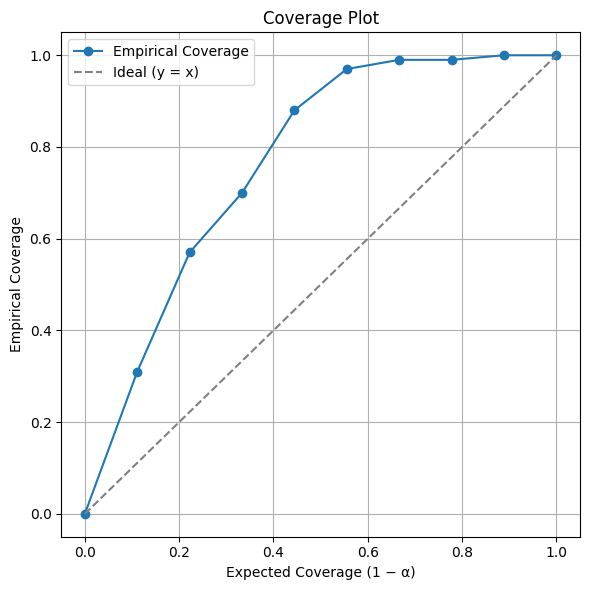

In [9]:
from utils_result_viz import plot_expected_vs_empirical

plot_expected_vs_empirical(rslt)

## Uncertainty Plot


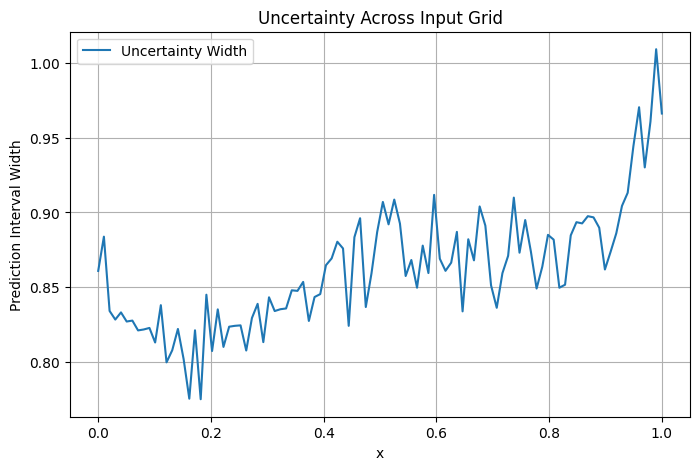

In [10]:
from utils_result_metrics import plot_uncertainty
plot_uncertainty(pred_set, x_grid)